In [1]:
%matplotlib inline
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist
from matplotlib import gridspec
import cv2
import os
import time
from class_based_preprocessing import PreProcessing
from model import TripletLoss


/usr/local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:529: FutureWarning: Passing (type, 1) or 

In [2]:
# Let's define our flags first
data_src = './ChallengeImages2/'
learning_rate = 0.01
train_iter = 250
batch_size = 128
momentum = 0.99
step = 50    
imageHeight = 50
imageWidth = 150

In [3]:
# Now let's obtain our train dataset
trainDataset = PreProcessing(data_src, 'training')

Loading Geological Similarity Dataset...
Setting min directory to 0 and max directory to 64 in data mode training
Dataset loaded successfully.
Preprocessing Done. Summary:
Images : (592, 50, 150, 3)
Labels : (592,)
Unique label : [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49]


In [4]:
# Now let's obtain our validation dataset
validationDataset = PreProcessing(data_src, 'validation')

Loading Geological Similarity Dataset...
Setting min directory to 65 and max directory to 84 in data mode validation
Dataset loaded successfully.
Preprocessing Done. Summary:
Images : (180, 50, 150, 3)
Labels : (180,)
Unique label : [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]


In [5]:
#helper function to plot image
def show_image(idxs, data):
    if type(idxs) != np.ndarray:
        idxs = np.array([idxs])
    fig = plt.figure()
    gs = gridspec.GridSpec(1,len(idxs))
    for i in range(len(idxs)):
        ax = fig.add_subplot(gs[0,i])
        ax.imshow(data[idxs[i],:,:,:])
        ax.axis('off')
    plt.show()

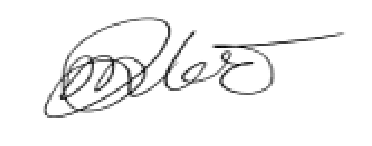

In [6]:
# Let's look at an image in our training data
show_image(np.asarray([0]), trainDataset.images)



In [7]:
'''
Given two matrices by size N x M, compute the row wise cosine similarity,
and output a matrix R of size N x 1, where R[i] is the cosine similarity
between output1[i] and output2[i].
'''
def computeCosSimilarity(output1, output2):
    dot_product = tf.reduce_sum(output1*output2, 1)
    norm_1 = tf.sqrt(tf.reduce_sum(tf.pow(output1, 2), 1))
    norm_2 = tf.sqrt(tf.reduce_sum(tf.pow(output2, 2), 1))
    return dot_product / (norm_1 * norm_2)

In [8]:
import bisect
def findOptimalPoint(arr1, arr2):
    arr1.sort()
    arr2.sort()
    optimalSatisfied = 0
    bestPoint = 0.0
    for i in range(len(arr1)):
        numSatisfiedIn1 = len(arr1) - i
        numSatisfiedIn2 = bisect.bisect_left(arr2, arr1[i], lo=0, hi=len(arr2))
        if numSatisfiedIn1 + numSatisfiedIn2 > optimalSatisfied:
            optimalSatisfied = numSatisfiedIn1 + numSatisfiedIn2
            bestPoint = arr1[i]
    return optimalSatisfied, bestPoint    

In [11]:
model = TripletLoss()

In [39]:
# Let's train the data now
dims = [imageHeight, imageWidth, 3]
placeholder_shape = [None] + dims
print("placeholder_shape", placeholder_shape)

# Setup Network
next_batch = trainDataset.get_triplets_batch
anchor_input = tf.placeholder(tf.float32, placeholder_shape, name='anchor_input')
positive_input = tf.placeholder(tf.float32, placeholder_shape, name='positive_input')
negative_input = tf.placeholder(tf.float32, placeholder_shape, name='negative_input')

margin = 0.5
# Will be of size N x 28(?)
anchor_output = model.conv_net(anchor_input, reuse=tf.AUTO_REUSE)
positive_output = model.conv_net(positive_input, reuse=tf.AUTO_REUSE)
negative_output = model.conv_net(negative_input, reuse=tf.AUTO_REUSE)

similarity_pos_neg = computeCosSimilarity(positive_output, negative_output)
similarity_pos_anchor = computeCosSimilarity(positive_output, anchor_output)
similarity_anchor_neg = computeCosSimilarity(negative_output, anchor_output)

loss = model.triplet_loss(anchor_output, positive_output, negative_output, margin)

# validation Network
next_batch_val = validationDataset.get_triplets_batch
anchor_input_val = tf.placeholder(tf.float32, placeholder_shape, name='anchor_input_val')
positive_input_val = tf.placeholder(tf.float32, placeholder_shape, name='positive_input_val')
negative_input_val = tf.placeholder(tf.float32, placeholder_shape, name='negative_input_val')

anchor_output_val = model.conv_net(anchor_input_val, reuse=tf.AUTO_REUSE)
positive_output_val = model.conv_net(positive_input_val, reuse=tf.AUTO_REUSE)
negative_output_val = model.conv_net(negative_input_val, reuse=tf.AUTO_REUSE)

similarity_pos_neg_val = computeCosSimilarity(positive_output_val, negative_output_val)
similarity_pos_anchor_val = computeCosSimilarity(positive_output_val, anchor_output_val)
similarity_anchor_neg_val = computeCosSimilarity(negative_output_val, anchor_output_val)
validation_loss = model.triplet_loss(anchor_output_val, positive_output_val, negative_output_val, margin)

# Setup Optimizer
global_step = tf.Variable(0, trainable=False)

train_step = tf.train.MomentumOptimizer(learning_rate, momentum, use_nesterov=True).minimize(loss, global_step=global_step)

# Start Training
saver = tf.train.Saver()
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())

    # Setup Tensorboard
    tf.summary.scalar('step', global_step)
    tf.summary.scalar('loss', loss)
    for var in tf.trainable_variables():
        tf.summary.histogram(var.op.name, var)
    merged = tf.summary.merge_all()
    writer = tf.summary.FileWriter('train.log', sess.graph)

    # Train iter
    for i in range(train_iter):
        batch_anchor, batch_positive, batch_negative = next_batch(batch_size)

        _, l, summary_str, sim_p_n, sim_p_a, sim_n_a = sess.run([train_step, loss, merged, similarity_pos_neg, similarity_pos_anchor, similarity_anchor_neg],
                                     feed_dict={anchor_input: batch_anchor, positive_input: batch_positive, negative_input: batch_negative})
        
#         # TODO: finish this
#         batch_anchor_val, batch_positive_val, batch_negative_val = next_batch_val(batch_size)
#         l_val, sim_p_n_val, sim_p_a_val, sim_n_a_val = sess.run([validation_loss, similarity_pos_neg_val, similarity_pos_anchor_val, similarity_anchor_neg_val],
#                 feed_dict={anchor_input_val: batch_anchor_val, positive_input_val: batch_positive_val, negative_input_val: batch_negative_val})
        
        
        '''
        Say you have two sorted arrays arr1, arr2. Find a point x in arr2 such that the number of points greater than 
        x in arr2 + number of points less than x in arr1 is maximal.
        '''
        pointsSatisfied, seperationPoint = findOptimalPoint(sim_p_a, sim_n_a)
        trainAccuracy = pointsSatisfied * 1.0 / (len(sim_p_a) + len(sim_n_a))
        
        writer.add_summary(summary_str, i)
        print("#%d - Loss" % i, l)
        print("#%d - Training Accuracy with seperation point %f %f" % (i, trainAccuracy, seperationPoint))

        if (i + 1) % step == 0:
            saver.save(sess, "model_triplet/model.ckpt")
    saver.save(sess, "model_triplet/model.ckpt")
print('Training completed successfully.')

placeholder_shape [None, 50, 150, 3]


ValueError: Variable conv1/weights/Momentum/ already exists, disallowed. Did you mean to set reuse=True or reuse=tf.AUTO_REUSE in VarScope? Originally defined at:

  File "<ipython-input-9-a51eb04667a9>", line 29, in <module>
    train_step = tf.train.MomentumOptimizer(learning_rate, momentum, use_nesterov=True).minimize(loss, global_step=global_step)
  File "/usr/local/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/usr/local/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3254, in run_ast_nodes
    if (await self.run_code(code, result,  async_=asy)):


In [18]:
# only forward pass for one image(for test purposes)
img_placeholder = tf.placeholder(tf.float32, [None, 50, 150, 3], name='img')
net = model.conv_net(img_placeholder, reuse=tf.AUTO_REUSE)

In [19]:
model_path = './model_triplet/'

In [20]:
# Let's now compute validation data embeddings
saver = tf.train.Saver()
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    ckpt = tf.train.get_checkpoint_state(model_path)
    saver.restore(sess, model_path+"model.ckpt")
    validation_vectors = sess.run(net, feed_dict={img_placeholder:validationDataset.images}) 
normalized_validation_vectors = validation_vectors/np.linalg.norm(validation_vectors, axis=1).reshape(-1,1)

INFO:tensorflow:Restoring parameters from ./model_triplet/model.ckpt


In [21]:
print(normalized_validation_vectors.shape)

(180, 280)


In [22]:
def computeCosSimilarityVec(output1, output2):
    dot_product = np.sum(output1*output2)
    norm_1 = np.sqrt(np.sum(np.square(output1)))
    norm_2 = np.sqrt(np.sum(np.square(output2)))
    return dot_product / (norm_1 * norm_2)

In [26]:
def classSimilarities(normalized_vectors, labels):
    # find the best separation point for validation dataset
    sameClassSimilarities = []
    diffClassSimilarities = []
    # Calculate the similarities of the vector representations of training images from different classes
    for i in range(len(normalized_vectors)):
        for j in range(i + 1, len(normalized_vectors)):
            curSimilarity = computeCosSimilarityVec(normalized_vectors[i], normalized_vectors[j])
            if labels[i] == labels[j]:
                sameClassSimilarities.append(curSimilarity)
            else:
                diffClassSimilarities.append(curSimilarity)
    return sameClassSimilarities, diffClassSimilarities

In [29]:
def getForwardPassResults(dataset):
    # Let's now compute validation data embeddings
    saver = tf.train.Saver()
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        ckpt = tf.train.get_checkpoint_state(model_path)
        saver.restore(sess, model_path+"model.ckpt")
        output_vectors = sess.run(net, feed_dict={img_placeholder:dataset.images}) 
    normalized_output_vectors = output_vectors/np.linalg.norm(output_vectors, axis=1).reshape(-1,1)
    return normalized_output_vectors

In [30]:
sameClassSimilarities, diffClassSimilarities = classSimilarities(normalized_validation_vectors, validationDataset.labels)

In [33]:
optimalSatisfied, bestPoint = findOptimalPoint(sameClassSimilarities, diffClassSimilarities)
print(optimalSatisfied)
# the number of points that are greater than or equal to the best point in sameClassSimilarities + 
# the number of points that are less than the best point in diffClassSimilarities
# best point is the point that maximizes the above number
print(bestPoint)

15505
0.9996848


In [34]:
valAccuracy = optimalSatisfied * 1.0 / (len(sameClassSimilarities) + len(diffClassSimilarities))
print(valAccuracy)

0.9624456859093731


In [35]:
# let's load the test dataset
testDataset = PreProcessing(data_src, 'test')

Loading Geological Similarity Dataset...
Setting min directory to 85 and max directory to 100 in data mode test
Dataset loaded successfully.
Preprocessing Done. Summary:
Images : (168, 50, 150, 3)
Labels : (168,)
Unique label : [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13]


In [36]:
normalized_test_results = getForwardPassResults(testDataset)

INFO:tensorflow:Restoring parameters from ./model_triplet/model.ckpt


In [37]:
correct = 0
wrong = 0
for i in range(len(normalized_test_results)):
    for j in range(i + 1, len(normalized_test_results)):
        curSimilarity = computeCosSimilarityVec(normalized_test_results[i], normalized_test_results[j])
        if curSimilarity >= bestPoint and testDataset.labels[i] == testDataset.labels[j]:
            correct += 1
        elif curSimilarity < bestPoint and testDataset.labels[i] != testDataset.labels[j]:
            correct += 1
        else:
            wrong += 1
print(correct * 1.0 / (correct + wrong))

0.9626461362988309


In [39]:
# Find k nearest neighbour using cosine similarity
def find_k_nn(normalized_train_vectors,vec,k):
    dist_arr = np.matmul(normalized_train_vectors, vec.T)
    return np.argsort(-dist_arr.flatten())[:k]

In [41]:
normalized_val_results = getForwardPassResults(validationDataset)

INFO:tensorflow:Restoring parameters from ./model_triplet/model.ckpt


In [44]:
normalized_train_results = getForwardPassResults(trainDataset)

INFO:tensorflow:Restoring parameters from ./model_triplet/model.ckpt


In [47]:
normalized_test_results = getForwardPassResults(testDataset)

INFO:tensorflow:Restoring parameters from ./model_triplet/model.ckpt


In [85]:
def getKNNAccuracy(forwardPassResults, dataset):
    correct = 0
    wrong = 0
    for i in range(len(forwardPassResults)):
        normalized_vec = forwardPassResults[i]
        s_time = time.time()
        k = 10
        candidate_index = find_k_nn(forwardPassResults, normalized_vec, k)
        #print('Total time to find nn: {:0.2f} ms'.format((time.time()-s_time)*1000))
        curLabel = dataset.labels[i]
        nnLabel = dataset.labels[candidate_index[1]]
        if curLabel != nnLabel:
            wrong += 1
            print("LABELS DON'T MATCH")
#             fig = plt.figure(figsize=(10, 0.8))
#             idxs = [i]
#             print(idxs)
#             gs = gridspec.GridSpec(1, len(idxs))
#             # plot test image
#             for i in range(len(idxs)):
#                 ax = fig.add_subplot(gs[0, i])
#                 ax.imshow(dataset.images[idxs[i], :, :, :])
#                 ax.axis('off')
#             plt.show()
            show_image(i, dataset.images)
            # plot similar images
            show_image(candidate_index[1], dataset.images)
            #show_image(candidate_index[1], dataset.images)            
        else:
            if correct % 100 == 0:
                print("LABELS MATCH")
                show_image(i, dataset.images)
                show_image(candidate_index[1], dataset.images)

            correct += 1
    return(correct*1.0/(correct+wrong))    

LABELS MATCH


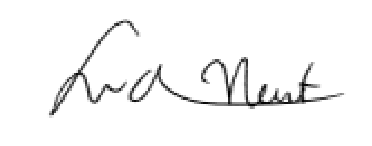

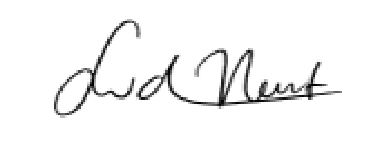

LABELS DON'T MATCH


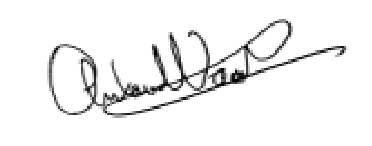

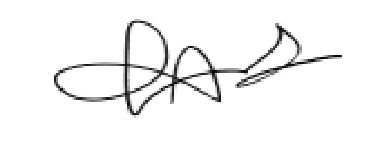

LABELS MATCH


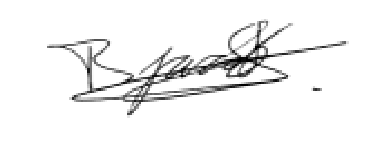

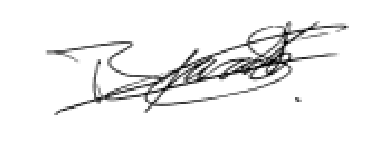

LABELS DON'T MATCH


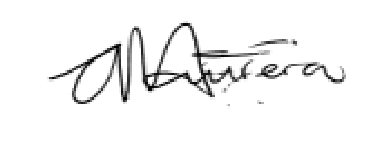

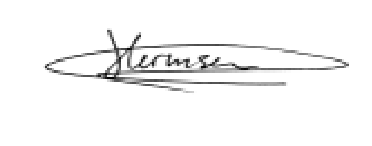

0.9880952380952381


In [86]:
print(getKNNAccuracy(normalized_test_results, testDataset))

LABELS MATCH


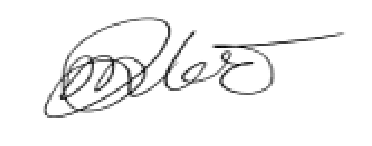

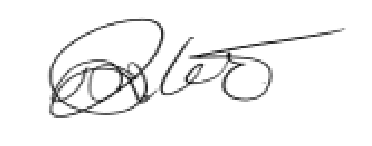

LABELS DON'T MATCH


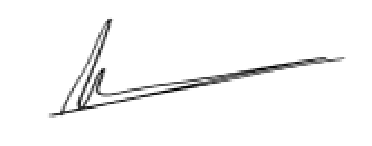

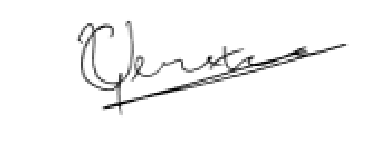

LABELS DON'T MATCH


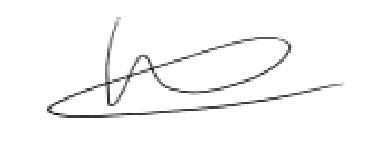

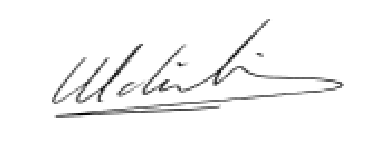

LABELS DON'T MATCH


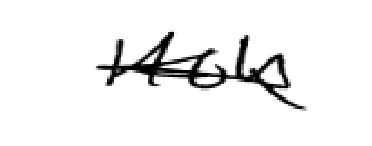

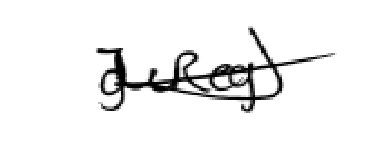

LABELS DON'T MATCH


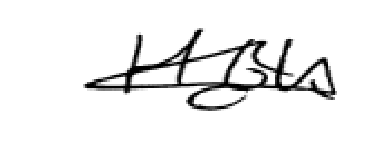

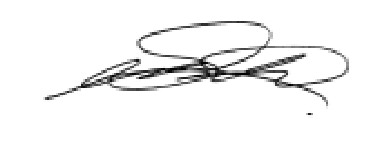

LABELS DON'T MATCH


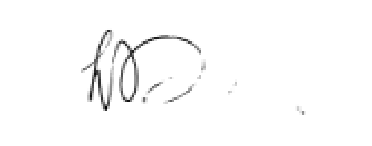

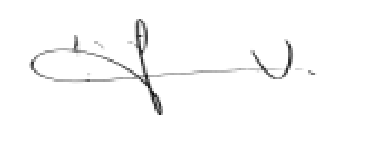

LABELS DON'T MATCH


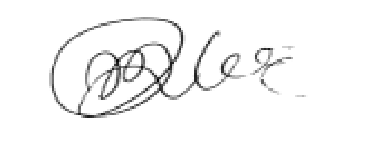

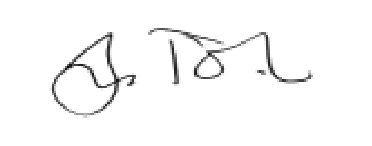

LABELS DON'T MATCH


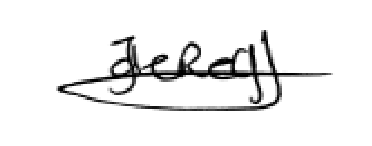

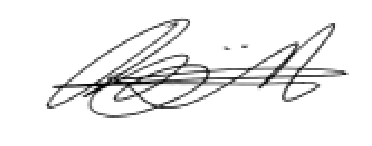

LABELS DON'T MATCH


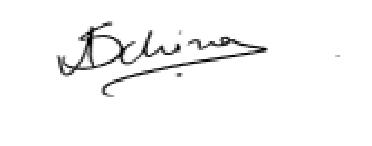

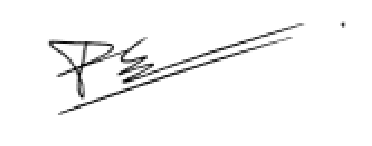

LABELS MATCH


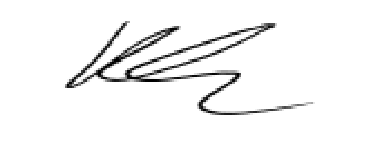

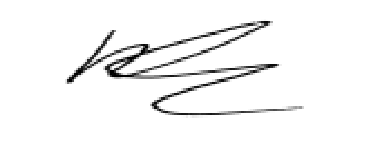

LABELS DON'T MATCH


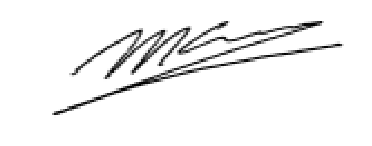

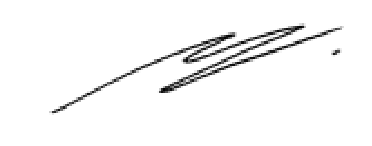

LABELS DON'T MATCH


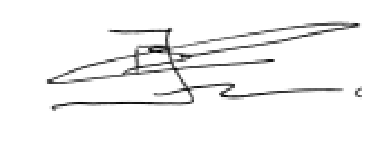

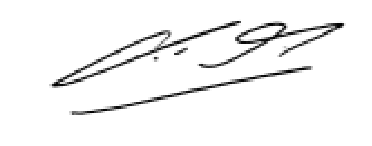

LABELS DON'T MATCH


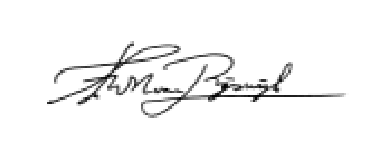

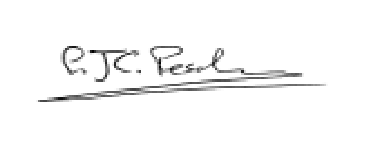

LABELS DON'T MATCH


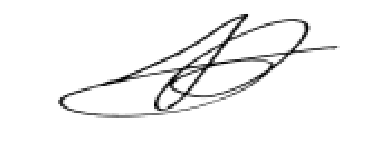

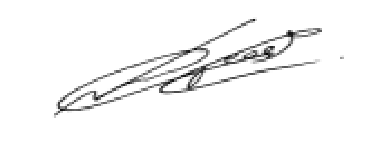

LABELS DON'T MATCH


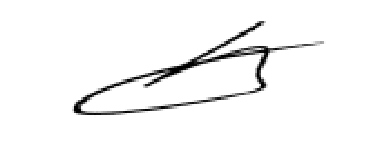

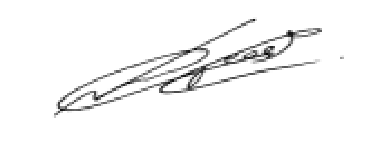

LABELS MATCH


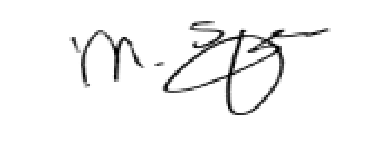

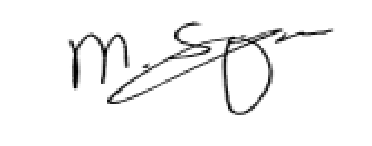

LABELS DON'T MATCH


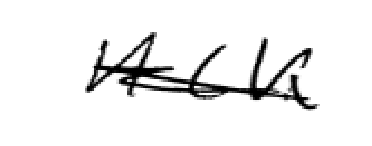

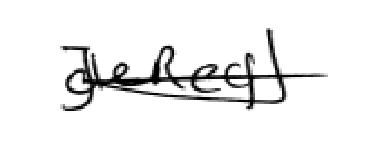

LABELS DON'T MATCH


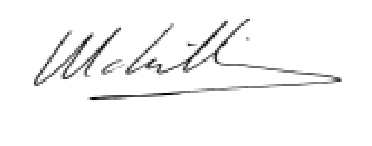

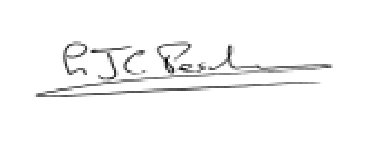

LABELS DON'T MATCH


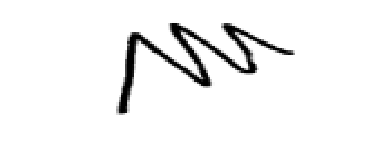

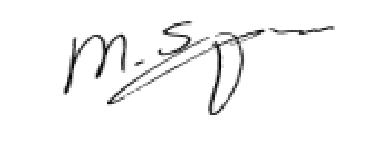

LABELS DON'T MATCH


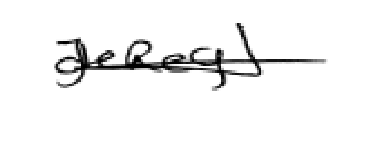

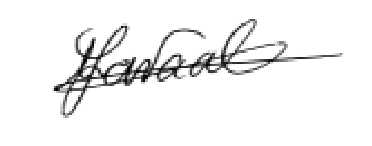

LABELS DON'T MATCH


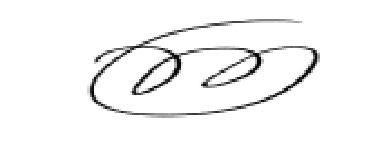

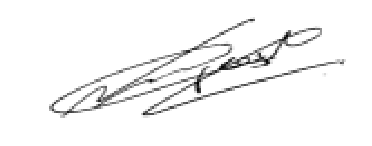

LABELS DON'T MATCH


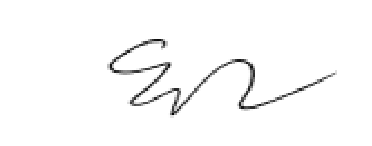

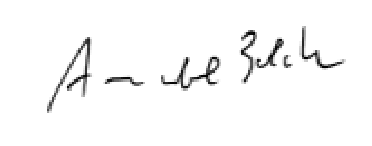

LABELS MATCH


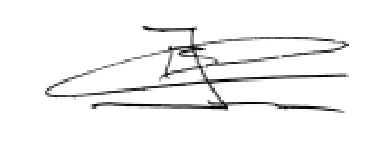

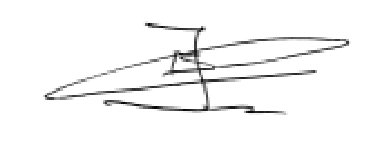

LABELS DON'T MATCH


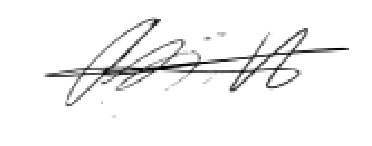

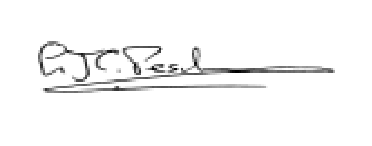

LABELS DON'T MATCH


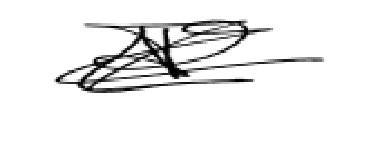

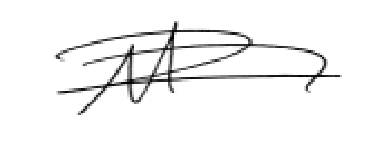

LABELS DON'T MATCH


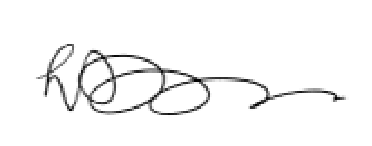

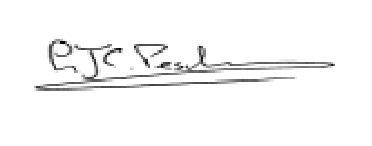

LABELS DON'T MATCH


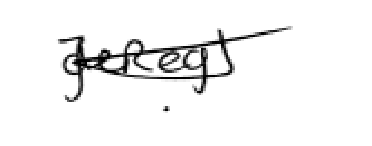

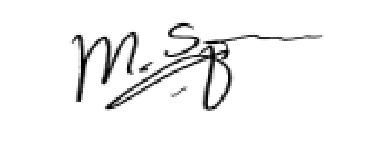

LABELS MATCH


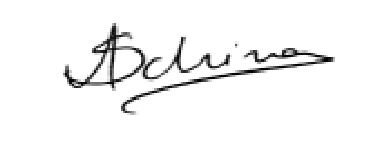

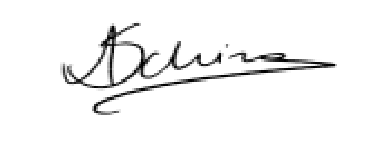

LABELS DON'T MATCH


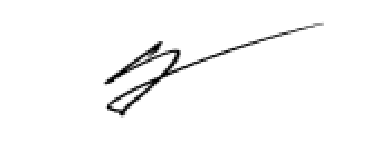

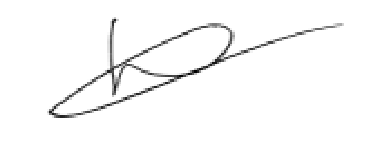

LABELS DON'T MATCH


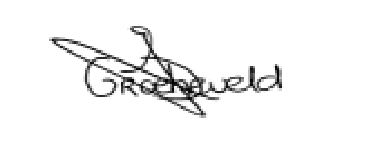

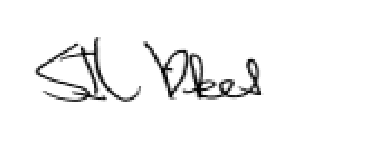

LABELS DON'T MATCH


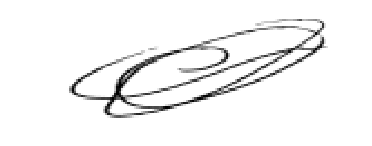

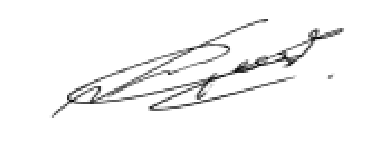

LABELS DON'T MATCH


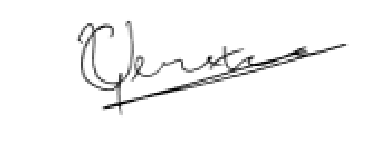

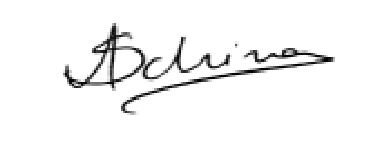

LABELS DON'T MATCH


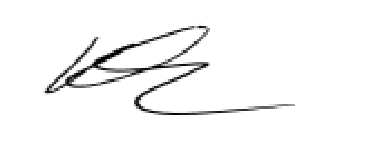

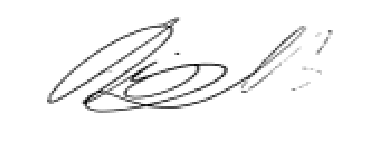

LABELS DON'T MATCH


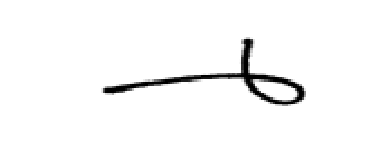

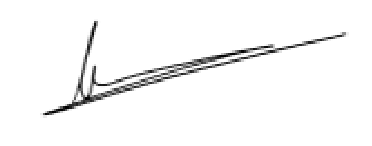

LABELS DON'T MATCH


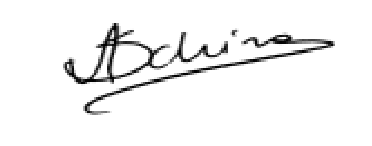

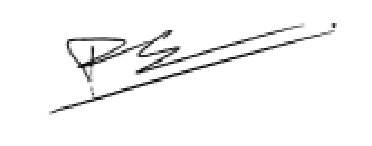

LABELS DON'T MATCH


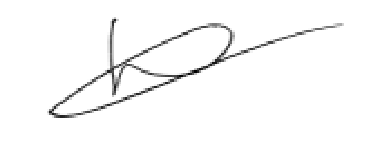

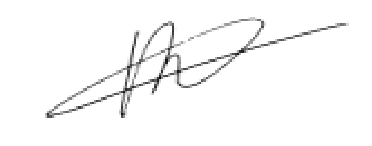

LABELS DON'T MATCH


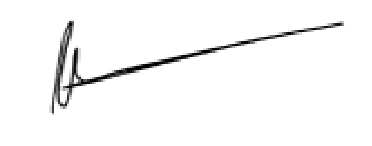

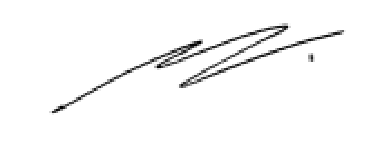

LABELS MATCH


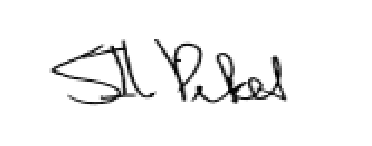

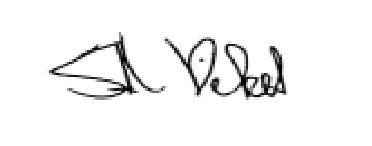

LABELS DON'T MATCH


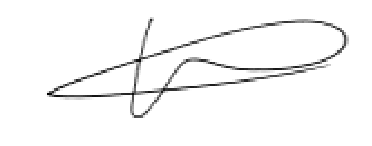

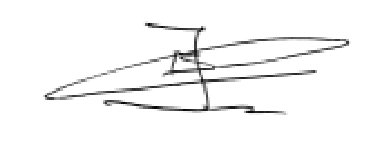

0.9442567567567568


In [87]:
print(getKNNAccuracy(normalized_train_results, trainDataset))

In [51]:
print(getKNNAccuracy(normalized_val_results, validationDataset))

0.9444444444444444


## Triplet Loss

In [ ]:
model = TripletLoss()

In [ ]:
# Input and Output Tensor
img_placeholder = tf.placeholder(tf.float32, [None, 50, 150, 3], name='img')
net = model.conv_net(img_placeholder, reuse=tf.AUTO_REUSE)

In [ ]:
# Generate random index from test_images corpus and display the image
idx = np.random.randint(0, len(dataset.images_test))
im = dataset.images_test[idx]

#show the test image
print("********** QUERY IMAGE **********")
show_image(idx, dataset.images_test)

## Find k nearest neighbour using cosine similarity [slower]

In [ ]:
correct = 0
wrong = 0
for i in range(len(normalized_search_vectors)):
    normalized_search_vec = normalized_search_vectors[i]
    s_time = time.time()
    k = 10
    candidate_index = find_k_nn(normalized_training_vectors, normalized_search_vec, k)
    print('Total time to find nn: {:0.2f} ms'.format((time.time()-s_time)*1000))
    fig = plt.figure(figsize=(10, 0.8))
    idxs = [idx]
    gs = gridspec.GridSpec(1, len(idxs))
    # plot test image
    for i in range(len(idxs)):
        ax = fig.add_subplot(gs[0, i])
        ax.imshow(test_images[idxs[i], :, :, :])
        ax.axis('off')
    plt.show()
    # plot similar images
    show_image(candidate_index, train_images)
    #   print("Class of Actual image:", test_label[i])
    #print("Class of Similar images:", train_label[candidate_index][0])
    actualClass = test_label[i]
    mostSimilarClass = train_label[candidate_index][0]
    if actualClass != mostSimilarClass:
        wrong += 1
    else:
        correct += 1
print(correct*1.0/(correct+wrong))

In [ ]:
similarityMap = {}
sameClassSimilarities = []
diffClassSimilarities = []
# Calculate the similarities of the vector representations of training images from different classes
for i in range(len(normalized_training_vectors)):
    for j in range(i + 1, len(normalized_training_vectors)):
        if i not in similarityMap:
            similarityMap[i] = {}
        curSimilarity = computeCosSimilarity(normalized_training_vectors[i], normalized_training_vectors[j])
        similarityMap[i][j] = curSimilarity
        if train_label[i] == train_label[j]:
            sameClassSimilarities.append(curSimilarity)
        else:
            diffClassSimilarities.append(curSimilarity)

In [ ]:
def linear_map(val, fromMin, fromMax, toMin, toMax):
    return (val - fromMin)*(toMax-toMin)/(fromMax-fromMin) + toMin

In [ ]:
fromMin = min(min(sameClassSimilarities), min(diffClassSimilarities))
fromMax = max(max(sameClassSimilarities), max(diffClassSimilarities))
sameClass = []
diffClass = []
# do linear mapping between similarities
for i in range(len(normalized_training_vectors)):
    for j in range(i + 1, len(normalized_training_vectors)):
        curSimilarity = similarityMap[i][j]
        mappedSimilarity = linear_map(curSimilarity, fromMin, fromMax, 0.0, 1.0)
        if train_label[i] == train_label[j]:
            sameClass.append(mappedSimilarity)
        else:
            diffClass.append(mappedSimilarity)
print(sum(sameClass) / len(sameClass))
print(sum(diffClass) / len(diffClass))
print(min(min(sameClass), min(diffClass)))


In [ ]:
correct = 0.0
wrong = 0.0
m = 100
for i in range(len(normalized_search_vectors)):
    for j in range(i + 1, len(normalized_search_vectors)):
        curSimilarity = computeCosSimilarity(normalized_search_vectors[i], normalized_search_vectors[j])
        mappedSimilarity = linear_map(curSimilarity, fromMin, fromMax, 0.0, 1.0)
        if test_label[i] == test_label[j] and mappedSimilarity >= 0.9:
            correct += 1
        elif test_label[i] != test_label[j] and mappedSimilarity < 0.9:
            correct += 1
        else:
            wrong += 1
        m = min(m, mappedSimilarity)
            
            
print(correct / (correct + wrong))
print(m)

In [ ]:
def l2norm(output1, output2):
    return np.sqrt(np.sum(np.square(output1-output2)))

In [ ]:
# let's now try the same with l2norm
similarityMap = {}
sameClassSimilarities = []
diffClassSimilarities = []
# Calculate the similarities of the vector representations of training images from different classes
for i in range(len(normalized_training_vectors)):
    for j in range(i + 1, len(normalized_training_vectors)):
        if i not in similarityMap:
            similarityMap[i] = {}
        curSimilarity = l2norm(normalized_training_vectors[i], normalized_training_vectors[j])
        similarityMap[i][j] = curSimilarity
        if train_label[i] == train_label[j]:
            sameClassSimilarities.append(curSimilarity)
        else:
            diffClassSimilarities.append(curSimilarity)
print(min(diffClassSimilarities))
print(max(diffClassSimilarities))
print(min(sameClassSimilarities))
print(max(sameClassSimilarities))


In [ ]:
correct = 0
wrong = 0
for i in range(len(normalized_training_vectors)):
    for j in range(i + 1, len(normalized_training_vectors)):
        curSimilarity = l2norm(normalized_training_vectors[i], normalized_training_vectors[j])
        if curSimilarity <= 0.01 and train_label[i] == train_label[j]:
            correct += 1
        elif curSimilarity > 0.01 and train_label[i] != train_label[j]:
            correct += 1
        else:
            wrong += 1
print(correct*1.0/(correct + wrong))

In [ ]:
# Now let's try on test data
correct = 0
wrong = 0
for i in range(len(normalized_search_vectors)):
    for j in range(i + 1, len(normalized_search_vectors)):
        curSimilarity = l2norm(normalized_search_vectors[i], normalized_search_vectors[j])
        if curSimilarity <= 0.01 and test_label[i] == test_label[j]:
            correct += 1
        elif curSimilarity > 0.01 and test_label[i] != test_label[j]:
            correct += 1
        else:
            wrong += 1
print(correct*1.0/(correct + wrong))

## VISUALIZATION 

In [ ]:
#helper function to plot imageS
def show_top_k_images(indx_list,test_image_indexes, train_data, test_data):
    fig = plt.figure(figsize=(20, 40))
    gs = gridspec.GridSpec(len(indx_list),len(indx_list[0])+2)
    for i in range(len(indx_list)):
        ax = fig.add_subplot(gs[i,0])
        ax.imshow(test_data[test_image_indexes[i],:,:,:])
        ax.axis('off')
        for j in range(len(indx_list[0])):
            ax = fig.add_subplot(gs[i,j+2])
            ax.imshow(train_data[indx_list[i][j],:,:,:])
            ax.axis('off')
    plt.savefig('./figures/similar_images.jpg')
    plt.show()

In [ ]:
K = 10
N = 20
indx_list = []
test_image_indexes = []
_test_images = []
for i in range(N):
    idx = i
    test_image_indexes.append(idx)
    _test_images.append(test_images[idx])
    #run the test image through the network to get the test features
saver = tf.train.Saver()
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    ckpt = tf.train.get_checkpoint_state(model_path)
    saver.restore(sess, model_path+"model.ckpt")
    search_vectors = sess.run(net, feed_dict={img_placeholder:_test_images})
    
normalized_search_vecs = search_vectors/np.linalg.norm(search_vectors,axis=1).reshape(-1,1)
for i in range(len(normalized_search_vecs)):
    candidate_index = find_k_nn(normalized_training_vectors, normalized_search_vecs[i], K)
    indx_list.append(candidate_index)

In [ ]:
print('**Query Image**       *************************** Top %d Similar Images  ***************************' % K)
show_top_k_images(indx_list,test_image_indexes, train_images, test_images)

## Find k nearest neighbour using faiss [faster]

### prerequisite: faiss [install conda distribution: {conda install -c pytorch faiss-cpu}]

In [ ]:
import faiss

In [ ]:
def generate_db_index():
    saver = tf.train.Saver()
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        ckpt = tf.train.get_checkpoint_state(model_path)
        saver.restore(sess, model_path+"model.ckpt")
        train_vectors = sess.run(net, feed_dict={img_placeholder:train_images})   

    d = train_vectors.shape[1]    # Dimension of vector
    index = faiss.IndexFlatIP(d)  # Build the index
    normalized_train_vectors = train_vectors/np.linalg.norm(train_vectors,axis=1).reshape(-1,1)
    index.add(normalized_train_vectors)  # add vectors to the index
    print('faiss indexing done...')
    return index

In [ ]:
indexed_db = generate_db_index()

In [ ]:
#run the test image through the network to get the test features
saver = tf.train.Saver()
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    ckpt = tf.train.get_checkpoint_state(model_path)
    saver.restore(sess, model_path+"model.ckpt")
    search_vector = sess.run(net, feed_dict={img_placeholder:[im]})
    
s_time = time.time()
normalized_search_vec = search_vector/np.linalg.norm(search_vector)
k = 10

_, candidate_index = indexed_db.search(normalized_search_vec,k)
print('Total time to find nn: {:0.2f} ms'.format((time.time()-s_time)*1000))

fig = plt.figure(figsize=(0.8, 0.8))
idxs = [idx]
gs = gridspec.GridSpec(1, len(idxs))
# Display test image
for i in range(len(idxs)):
    ax = fig.add_subplot(gs[0, i])
    ax.imshow(test_images[idxs[i], :, :, :])
    ax.axis('off')
plt.show()
# Display similar images
show_image(candidate_index[0], train_images)
print("Index of Similar images:", candidate_index[0])

                           ---------------------- *** --------------------